In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [2]:
import pandas as pd
import numpy as np
from bayesian.train_bn import structure_learning, parameter_learning, parameter_learning_mix
from preprocess.discretization import get_nodes_type, discretization, inverse_discretization, code_categories
from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from visualization.visualization import draw_BN
from bayesian.calculate_accuracy import calculate_acc
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from copy import copy
from external.libpgm.sampleaggregator import SampleAggregator
import operator
from sklearn.metrics import accuracy_score, mean_squared_error
from scipy import stats
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
import math
from pomegranate import DiscreteDistribution
import random
from sklearn.model_selection import train_test_split

In [231]:
df_result_accuracy = pd.DataFrame(columns = ['Parameter', 'Strategy', 'Alg', 'accuracy'])
df_result_rmse = pd.DataFrame(columns = ['Parameter', 'Strategy', 'Alg', 'rmse'])

In [232]:
geo = pd.read_csv('../datasets/socio.csv')
columns = ['sex', 'relation', 'is_parent', 'has_pets', 'age', 'mean_tr', 'median_tr', 'tr_per_month']
geo = geo[columns]
geo.dropna(inplace=True)
geo.reset_index(inplace=True, drop=True)

In [233]:
geo['age'] = geo['age'].apply(lambda x: float(x))
geo['sex'] = geo['sex'].apply(lambda x: str(x))
geo['relation'] = geo['relation'].apply(lambda x: str(x))
geo['is_parent'] = geo['is_parent'].apply(lambda x: str(x))
geo['has_pets'] = geo['has_pets'].apply(lambda x: str(x))

In [234]:
geo_train, geo_test = train_test_split(geo, test_size=0.1)
geo_train.reset_index(inplace=True, drop=True)
geo_test.reset_index(inplace=True, drop=True)

In [235]:
geo_types = get_nodes_type(geo)
geo_types

{'sex': 'disc',
 'relation': 'disc',
 'is_parent': 'disc',
 'has_pets': 'disc',
 'age': 'cont',
 'mean_tr': 'cont',
 'median_tr': 'cont',
 'tr_per_month': 'cont'}

In [236]:
colums_for_code = []
columns_for_disc = []
for c in columns:
    if geo_types[c] == 'disc':
        colums_for_code.append(c)
    else:
        columns_for_disc.append(c)

In [237]:
geo_coded, label_coder = code_categories(geo_train, 'label', colums_for_code)
geo_discrete, coder = discretization(geo_coded, 'equal_frequency', columns_for_disc)
geo_only_discrete, discrete_coder = discretization(geo_train, 'equal_frequency', columns_for_disc)

# Hill Climbing

# Дискретная структра + смешанные параметры

In [238]:
bn_geo = structure_learning(geo_discrete, 'HC', 'MI', geo_types)

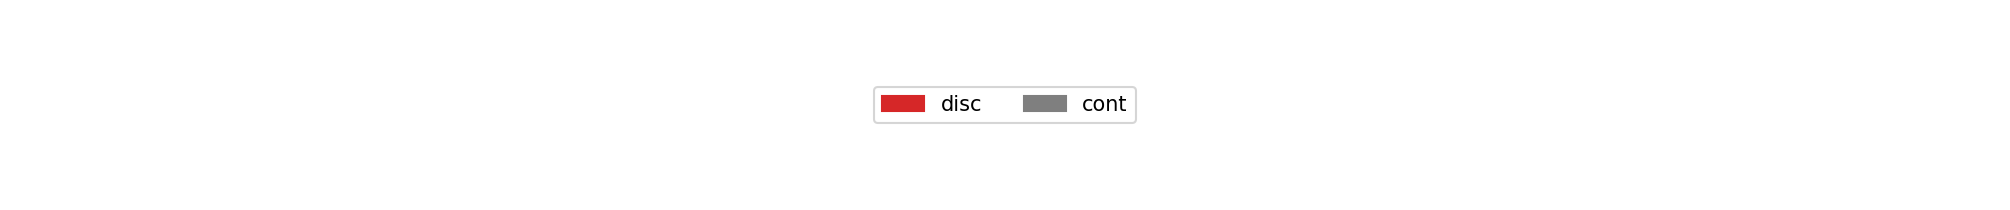

In [239]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [240]:
params = parameter_learning(geo_train, geo_types, bn_geo)

In [241]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [242]:
acc, rmse, real_data, pred_data = calculate_acc(geo_bn, geo_test, columns)

In [243]:
acc

{'sex': 0.56, 'relation': 0.27, 'is_parent': 0.74, 'has_pets': 0.95}

In [244]:
rmse

{'age': 12.21, 'mean_tr': 6504.48, 'median_tr': 5987.11, 'tr_per_month': 19.82}

In [245]:
for key in acc.keys():
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'HC', 'Alg':'D+M','accuracy':acc[key]}, ignore_index=True)
for key in rmse.keys():
    df_result_rmse = df_result_rmse.append({'Parameter': key, 'Strategy': 'HC', 'Alg':'D+M','rmse':rmse[key]}, ignore_index=True)

# Смешанная структура + смешанные параметры

In [246]:
bn_geo = structure_learning(geo_coded, 'HC', 'MI', geo_types)

c:\Users\anaxa\Documents\Projects\Mixed-Learning-of-Bayesian-Networks\bayesian\redef_HC.py:260: RuntimeWarning: overflow encountered in double_scalars
  delta_score = delta1 + delta2
c:\Users\anaxa\Documents\Projects\Mixed-Learning-of-Bayesian-Networks\bayesian\redef_HC.py:246: RuntimeWarning: overflow encountered in double_scalars
  delta1 = -1* nrow * (mi_old - mi_new)
c:\Users\anaxa\Documents\Projects\Mixed-Learning-of-Bayesian-Networks\bayesian\redef_HC.py:258: RuntimeWarning: overflow encountered in double_scalars
  delta2 = nrow * (mi_old - mi_new)
c:\Users\anaxa\Documents\Projects\Mixed-Learning-of-Bayesian-Networks\bayesian\redef_HC.py:246: RuntimeWarning: overflow encountered in double_scalars
  delta1 = -1* nrow * (mi_old - mi_new)
c:\Users\anaxa\Documents\Projects\Mixed-Learning-of-Bayesian-Networks\bayesian\redef_HC.py:258: RuntimeWarning: overflow encountered in double_scalars
  delta2 = nrow * (mi_old - mi_new)
c:\Users\anaxa\Documents\Projects\Mixed-Learning-of-Bayesian-

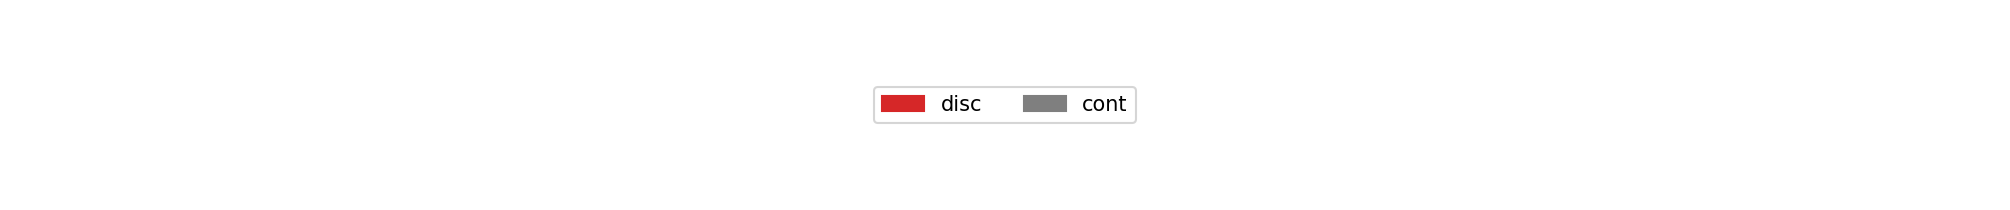

In [247]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [248]:
params = parameter_learning(geo_train, geo_types, bn_geo)

In [249]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [250]:
acc, rmse, real, pred = calculate_acc(geo_bn, geo_test, columns)

In [251]:
acc

{'sex': 0.56, 'relation': 0.27, 'is_parent': 0.74, 'has_pets': 0.95}

In [252]:
rmse

{'age': 12.21, 'mean_tr': 6314.49, 'median_tr': 5879.34, 'tr_per_month': 19.76}

In [253]:
for key in acc.keys():
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'HC', 'Alg':'M+M','accuracy':acc[key]}, ignore_index=True)
for key in rmse.keys():
    df_result_rmse = df_result_rmse.append({'Parameter': key, 'Strategy': 'HC', 'Alg':'M+M','rmse':rmse[key]}, ignore_index=True)

In [254]:
sample_m_m_hc_tr = pd.DataFrame(geo_bn.randomsample(5000))
sample_m_m_hc_tr = sample_m_m_hc_tr.loc[sample_m_m_hc_tr['tr_per_month'] > 0]
sample_m_m_hc = pd.DataFrame(geo_bn.randomsample(5000))
sample_m_m_hc = sample_m_m_hc.loc[sample_m_m_hc['median_tr'] > 0]

# Дискретная стурктура + дискретные параметры

In [255]:
geo_new_types = {'sex': 'disc',
 'relation': 'disc',
 'is_parent': 'disc',
 'has_pets': 'disc',
 'age': 'disc',
 'mean_tr': 'disc',
 'median_tr': 'disc',
 'tr_per_month': 'disc'}

In [256]:
bn_geo = structure_learning(geo_discrete, 'HC', 'MI', geo_new_types)

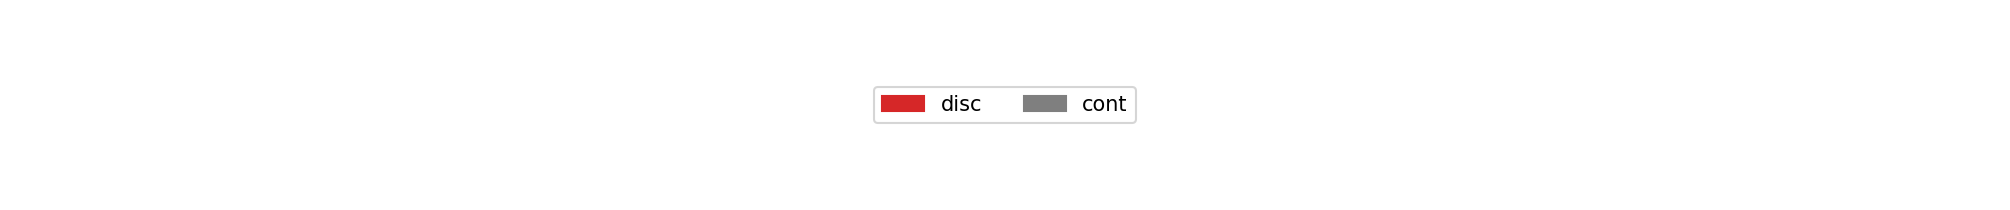

In [257]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [258]:
params = parameter_learning(geo_only_discrete, geo_new_types, bn_geo)

In [259]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [260]:
test_discrete = copy(geo_test)

In [261]:
test_discrete[columns_for_disc] = discrete_coder.transform(geo_test[columns_for_disc].values) 

In [262]:
for c in columns_for_disc:
    test_discrete[c] = test_discrete[c].apply(lambda x: int(x))
test_discrete

,sex,relation,is_parent,has_pets,age,mean_tr,median_tr,tr_per_month
0,2,5,0,0,4,4,4,1
1,2,6,0,0,2,3,2,4
2,2,6,1,0,4,1,2,4
3,2,7,0,0,4,4,4,1
4,1,0,1,0,3,3,2,4
...,...,...,...,...,...,...,...,...
374,1,4,0,0,4,3,3,1
375,1,6,1,0,1,2,2,0
376,1,5,0,0,3,1,2,3
377,2,3,0,0,2,3,3,0


In [263]:
acc, rmse, real, pred = calculate_acc(geo_bn, test_discrete, columns)

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future wil

In [264]:
acc

{'sex': 0.56,
 'relation': 0.27,
 'is_parent': 0.74,
 'has_pets': 0.95,
 'age': 0.0,
 'mean_tr': 0.0,
 'median_tr': 0.0,
 'tr_per_month': 0.0}

In [265]:
for key in colums_for_code:
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'HC', 'Alg':'D+D','accuracy':acc[key]}, ignore_index=True)

In [266]:
invers_real = inverse_discretization(pd.DataFrame(np.transpose(real[4:8]), columns=['age', 'mean_tr', 'median_tr', 'tr_per_month']), ['age', 'mean_tr', 'median_tr', 'tr_per_month'], discrete_coder)

In [267]:
invers_pred = inverse_discretization(pd.DataFrame(np.transpose(pred[4:8]), columns=['age','mean_tr', 'median_tr', 'tr_per_month']), ['age', 'mean_tr', 'median_tr', 'tr_per_month'], discrete_coder)

In [268]:
m = mean_squared_error(invers_real['age'], invers_pred['age'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'age', 'Strategy': 'HC', 'Alg':'D+D','rmse':m}, ignore_index=True)

In [269]:
m = mean_squared_error(invers_real['mean_tr'], invers_pred['mean_tr'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'mean_tr', 'Strategy': 'HC', 'Alg':'D+D','rmse':m}, ignore_index=True)

In [270]:
m = mean_squared_error(invers_real['median_tr'], invers_pred['median_tr'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'median_tr', 'Strategy': 'HC', 'Alg':'D+D','rmse':m}, ignore_index=True)

In [271]:
m = mean_squared_error(invers_real['tr_per_month'], invers_pred['tr_per_month'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'tr_per_month', 'Strategy': 'HC', 'Alg':'D+D','rmse':m}, ignore_index=True)

In [272]:
sample_d_d_hc = pd.DataFrame(geo_bn.randomsample(5000))
sample_d_d_hc = inverse_discretization(sample_d_d_hc, columns_for_disc, discrete_coder)

# Смешанная структура + дискретные параметры

In [273]:
bn_geo = structure_learning(geo_coded, 'HC', 'MI', geo_new_types)

c:\Users\anaxa\Documents\Projects\Mixed-Learning-of-Bayesian-Networks\bayesian\redef_HC.py:260: RuntimeWarning: overflow encountered in double_scalars
  delta_score = delta1 + delta2
c:\Users\anaxa\Documents\Projects\Mixed-Learning-of-Bayesian-Networks\bayesian\redef_HC.py:246: RuntimeWarning: overflow encountered in double_scalars
  delta1 = -1* nrow * (mi_old - mi_new)
c:\Users\anaxa\Documents\Projects\Mixed-Learning-of-Bayesian-Networks\bayesian\redef_HC.py:258: RuntimeWarning: overflow encountered in double_scalars
  delta2 = nrow * (mi_old - mi_new)
c:\Users\anaxa\Documents\Projects\Mixed-Learning-of-Bayesian-Networks\bayesian\redef_HC.py:246: RuntimeWarning: overflow encountered in double_scalars
  delta1 = -1* nrow * (mi_old - mi_new)
c:\Users\anaxa\Documents\Projects\Mixed-Learning-of-Bayesian-Networks\bayesian\redef_HC.py:258: RuntimeWarning: overflow encountered in double_scalars
  delta2 = nrow * (mi_old - mi_new)
c:\Users\anaxa\Documents\Projects\Mixed-Learning-of-Bayesian-

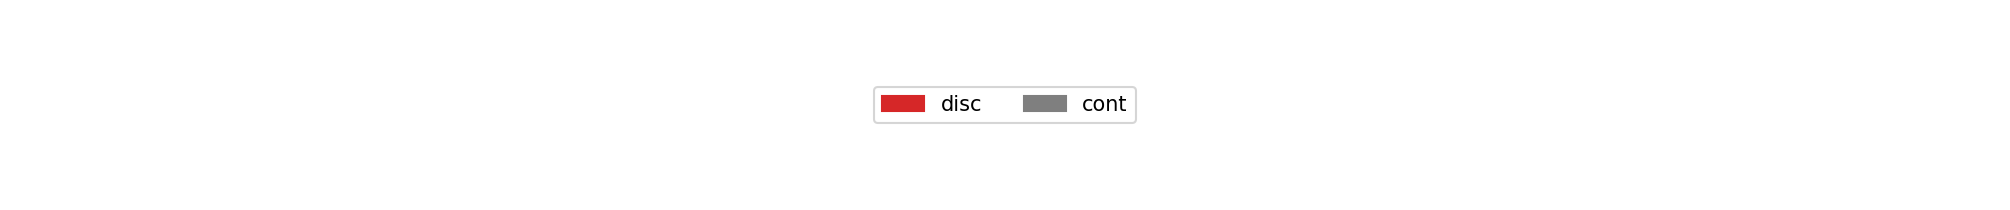

In [274]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [275]:
params = parameter_learning(geo_only_discrete, geo_new_types, bn_geo)

In [276]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [277]:
acc, rmse, real, pred = calculate_acc(geo_bn, test_discrete, columns)

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future wil

In [278]:
acc

{'sex': 0.56,
 'relation': 0.26,
 'is_parent': 0.74,
 'has_pets': 0.95,
 'age': 0.0,
 'mean_tr': 0.0,
 'median_tr': 0.0,
 'tr_per_month': 0.0}

In [279]:
for key in colums_for_code:
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'HC', 'Alg':'M+D','accuracy':acc[key]}, ignore_index=True)

In [280]:
invers_real = inverse_discretization(pd.DataFrame(np.transpose(real[4:8]), columns=['age', 'mean_tr', 'median_tr', 'tr_per_month']), ['age', 'mean_tr', 'median_tr', 'tr_per_month'], discrete_coder)

In [281]:
invers_pred = inverse_discretization(pd.DataFrame(np.transpose(pred[4:8]), columns=['age', 'mean_tr', 'median_tr', 'tr_per_month']), ['age', 'mean_tr', 'median_tr', 'tr_per_month'], discrete_coder)

In [282]:
m = mean_squared_error(invers_real['age'], invers_pred['age'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'age', 'Strategy': 'HC', 'Alg':'M+D','rmse':m}, ignore_index=True)

In [283]:
m = mean_squared_error(invers_real['mean_tr'], invers_pred['mean_tr'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'mean_tr', 'Strategy': 'HC', 'Alg':'M+D','rmse':m}, ignore_index=True)

In [284]:
m = mean_squared_error(invers_real['median_tr'], invers_pred['median_tr'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'median_tr', 'Strategy': 'HC', 'Alg':'M+D','rmse':m}, ignore_index=True)

In [285]:
m = mean_squared_error(invers_real['tr_per_month'], invers_pred['tr_per_month'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'tr_per_month', 'Strategy': 'HC', 'Alg':'M+D','rmse':m}, ignore_index=True)

# EVO

# Дискретная стурктура + смешанные параметры

In [286]:
bn_geo = structure_learning(geo_discrete, 'evo', 'MI', geo_types)

Cannot add to history: 'str' object has no attribute 'operation_type'
Best metric is 7.1323
Generation num: 0
max_depth: 3, no improvements: 0
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.1 min
Best metric is 6.634799999999999
Generation num: 1
max_depth: 3, no improvements: 0
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.1 min
Best metric is 6.634799999999999
Generation num: 2
max_depth: 3, no improvements: 1
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.2 min
Best metric is 5.5658
Generation num: 3
max_depth: 3, no improvements: 0
Cannot add to history: 'str' object has no attribute 'operation_type'
spe

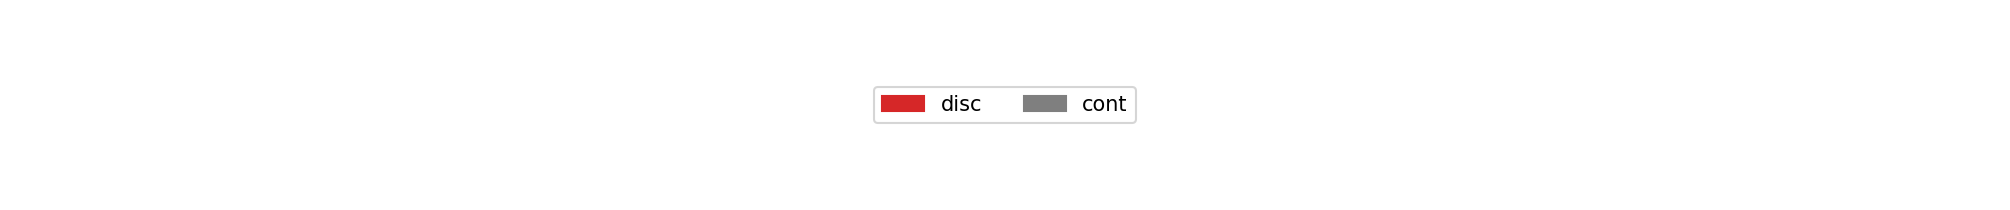

In [287]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [288]:
params = parameter_learning(geo_train, geo_types, bn_geo)

In [289]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [290]:
acc, rmse, real_data, pred_data = calculate_acc(geo_bn, geo_test, columns)

In [291]:
acc

{'sex': 0.56, 'relation': 0.27, 'is_parent': 0.74, 'has_pets': 0.95}

In [292]:
rmse

{'age': 12.15, 'mean_tr': 6367.19, 'median_tr': 6011.49, 'tr_per_month': 19.54}

In [293]:
for key in acc.keys():
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'evo', 'Alg':'D+M','accuracy':acc[key]}, ignore_index=True)
for key in rmse.keys():
    df_result_rmse = df_result_rmse.append({'Parameter': key, 'Strategy': 'evo', 'Alg':'D+M','rmse':rmse[key]}, ignore_index=True)

# Смешанная структура + смешанные параметры

In [294]:
bn_geo = structure_learning(geo_coded, 'evo', 'MI', geo_types)

Cannot add to history: 'str' object has no attribute 'operation_type'
Best metric is 21.591360801326836
Generation num: 0
max_depth: 3, no improvements: 0
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.4 min
Best metric is 13.884494431204732
Generation num: 1
max_depth: 3, no improvements: 0
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.6 min
Best metric is 11.80296920436803
Generation num: 2
max_depth: 3, no improvements: 0
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.8 min
Best metric is 11.80296920436803
Generation num: 3
max_depth: 3, no improvements: 1
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attrib

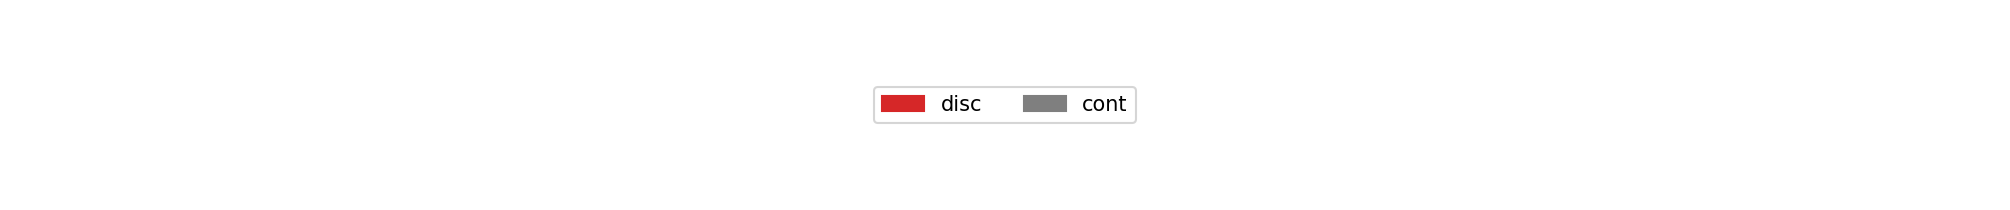

In [295]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [296]:
params = parameter_learning(geo_train, geo_types, bn_geo)

In [297]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [298]:
acc, rmse, real, pred = calculate_acc(geo_bn, geo_test, columns)

In [299]:
acc

{'sex': 0.56, 'relation': 0.27, 'is_parent': 0.74, 'has_pets': 0.95}

In [300]:
rmse

{'age': 12.19, 'mean_tr': 3094.93, 'median_tr': 5949.14, 'tr_per_month': 19.79}

In [301]:
for key in acc.keys():
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'evo', 'Alg':'M+M','accuracy':acc[key]}, ignore_index=True)
for key in rmse.keys():
    df_result_rmse = df_result_rmse.append({'Parameter': key, 'Strategy': 'evo', 'Alg':'M+M','rmse':rmse[key]}, ignore_index=True)

In [302]:
sample_m_m_evo_tr = pd.DataFrame(geo_bn.randomsample(5000))
sample_m_m_evo_tr = sample_m_m_evo_tr.loc[sample_m_m_evo_tr['tr_per_month'] > 0]
sample_m_m_evo = pd.DataFrame(geo_bn.randomsample(5000))
sample_m_m_evo = sample_m_m_evo.loc[sample_m_m_evo['median_tr'] > 0]

# Дискретная структура + дискретные параметры

In [303]:
geo_new_types = {'sex': 'disc',
 'relation': 'disc',
 'is_parent': 'disc',
 'has_pets': 'disc',
 'age': 'disc',
 'mean_tr': 'disc',
 'median_tr': 'disc',
 'tr_per_month': 'disc'}

In [304]:
bn_geo = structure_learning(geo_discrete, 'evo', 'MI', geo_new_types)

Cannot add to history: 'str' object has no attribute 'operation_type'
Best metric is 7.4896
Generation num: 0
max_depth: 3, no improvements: 0
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.1 min
Best metric is 7.4896
Generation num: 1
max_depth: 3, no improvements: 1
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.1 min
Best metric is 6.2824
Generation num: 2
max_depth: 3, no improvements: 0
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.1 min
Best metric is 6.2824
Generation num: 3
max_depth: 3, no improvements: 1
Numb

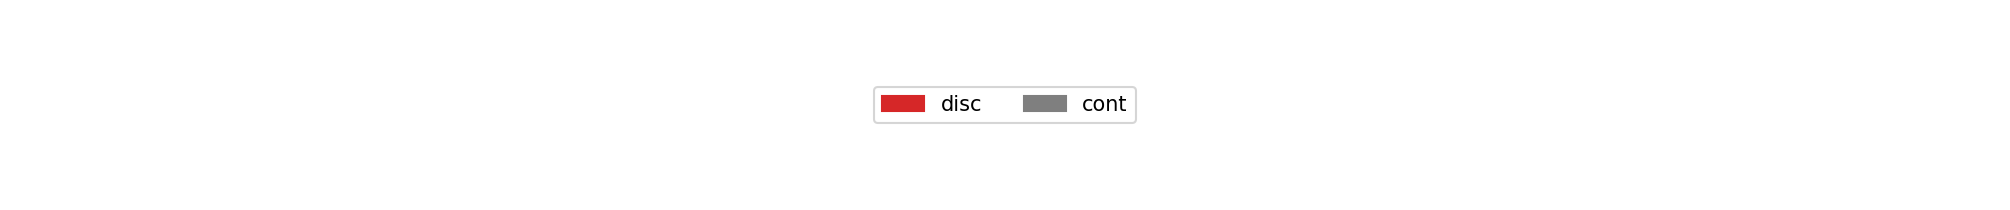

In [305]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [306]:
params = parameter_learning(geo_only_discrete, geo_new_types, bn_geo)

In [307]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [308]:
acc, rmse, real, pred = calculate_acc(geo_bn, test_discrete, columns)

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future wil

In [309]:
acc

{'sex': 0.56,
 'relation': 0.27,
 'is_parent': 0.74,
 'has_pets': 0.95,
 'age': 0.0,
 'mean_tr': 0.0,
 'median_tr': 0.0,
 'tr_per_month': 0.0}

In [310]:
for key in colums_for_code:
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'evo', 'Alg':'D+D','accuracy':acc[key]}, ignore_index=True)

In [311]:
invers_real = inverse_discretization(pd.DataFrame(np.transpose(real[4:8]), columns=['age', 'mean_tr', 'median_tr', 'tr_per_month']), ['age', 'mean_tr', 'median_tr', 'tr_per_month'], discrete_coder)

In [312]:
invers_pred = inverse_discretization(pd.DataFrame(np.transpose(pred[4:8]), columns=['age', 'mean_tr', 'median_tr', 'tr_per_month']), ['age', 'mean_tr', 'median_tr', 'tr_per_month'], discrete_coder)

In [313]:
m = mean_squared_error(invers_real['age'], invers_pred['age'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'age', 'Strategy': 'evo', 'Alg':'D+D','rmse':m}, ignore_index=True)

In [314]:
m = mean_squared_error(invers_real['mean_tr'], invers_pred['mean_tr'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'mean_tr', 'Strategy': 'evo', 'Alg':'D+D','rmse':m}, ignore_index=True)

In [315]:
m = mean_squared_error(invers_real['median_tr'], invers_pred['median_tr'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'median_tr', 'Strategy': 'evo', 'Alg':'D+D','rmse':m}, ignore_index=True)

In [316]:
m = mean_squared_error(invers_real['tr_per_month'], invers_pred['tr_per_month'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'tr_per_month', 'Strategy': 'evo', 'Alg':'D+D','rmse':m}, ignore_index=True)

In [317]:
sample_d_d_evo = pd.DataFrame(geo_bn.randomsample(5000))
sample_d_d_evo = inverse_discretization(sample_d_d_evo, columns_for_disc, discrete_coder)

# Смешанная структура + дискретные параметры

In [318]:
bn_geo = structure_learning(geo_coded, 'evo', 'MI', geo_new_types)

Cannot add to history: 'str' object has no attribute 'operation_type'
Best metric is 17.823995062865052
Generation num: 0
max_depth: 3, no improvements: 0
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.5 min
Best metric is 17.823995062865052
Generation num: 1
max_depth: 3, no improvements: 1
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.7 min
Best metric is 17.738130240826788
Generation num: 2
max_depth: 3, no improvements: 0
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has 

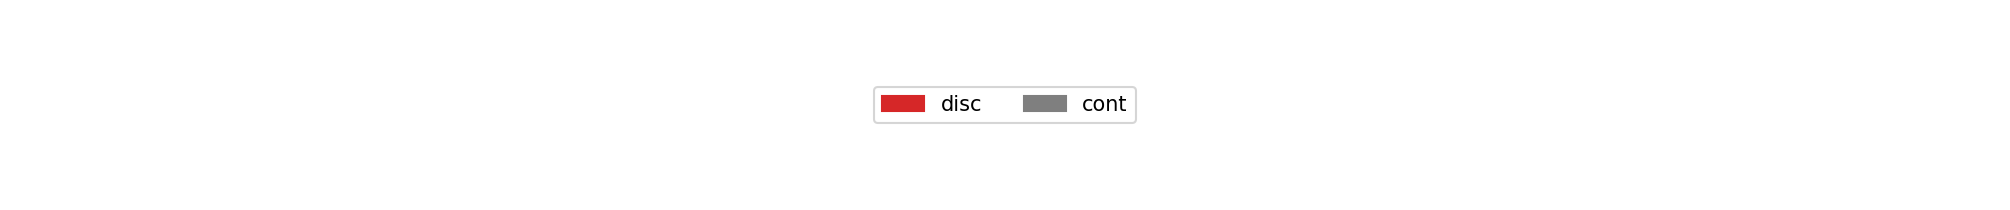

In [319]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [320]:
params = parameter_learning(geo_only_discrete, geo_new_types, bn_geo)

In [321]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [322]:
acc, rmse, real, pred = calculate_acc(geo_bn, test_discrete, columns)

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future wil

In [323]:
acc

{'sex': 0.56,
 'relation': 0.27,
 'is_parent': 0.74,
 'has_pets': 0.95,
 'age': 0.0,
 'mean_tr': 0.0,
 'median_tr': 0.0,
 'tr_per_month': 0.0}

In [324]:
for key in colums_for_code:
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'evo', 'Alg':'M+D','accuracy':acc[key]}, ignore_index=True)

In [325]:
invers_real = inverse_discretization(pd.DataFrame(np.transpose(real[4:8]), columns=['age', 'mean_tr', 'median_tr', 'tr_per_month']), ['age', 'mean_tr', 'median_tr', 'tr_per_month'], discrete_coder)

In [326]:
invers_pred = inverse_discretization(pd.DataFrame(np.transpose(pred[4:8]), columns=['age', 'mean_tr', 'median_tr', 'tr_per_month']), ['age', 'mean_tr', 'median_tr', 'tr_per_month'], discrete_coder)

In [327]:
m = mean_squared_error(invers_real['age'], invers_pred['age'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'age', 'Strategy': 'evo', 'Alg':'M+D','rmse':m}, ignore_index=True)

In [328]:
m = mean_squared_error(invers_real['mean_tr'], invers_pred['mean_tr'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'mean_tr', 'Strategy': 'evo', 'Alg':'M+D','rmse':m}, ignore_index=True)

In [329]:
m = mean_squared_error(invers_real['median_tr'], invers_pred['median_tr'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'median_tr', 'Strategy': 'evo', 'Alg':'M+D','rmse':m}, ignore_index=True)

In [330]:
m = mean_squared_error(invers_real['tr_per_month'], invers_pred['tr_per_month'], squared=False)
df_result_rmse = df_result_rmse.append({'Parameter': 'tr_per_month', 'Strategy': 'evo', 'Alg':'M+D','rmse':m}, ignore_index=True)

In [331]:
df_result_accuracy.to_csv('socio_results_disc.csv', index=False)
df_result_rmse.to_csv('socio_results_cont.csv', index=False)

In [332]:
geo_sample = geo.loc[geo['tr_per_month'] < 100]

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

<AxesSubplot:xlabel='age', ylabel='Density'>

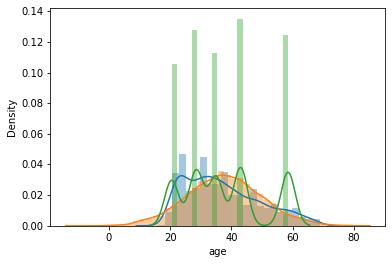

In [333]:
sns.distplot(geo['age'])
sns.distplot(sample_m_m_hc['age'])
sns.distplot(sample_d_d_hc['age'])

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

<AxesSubplot:xlabel='median_tr', ylabel='Density'>

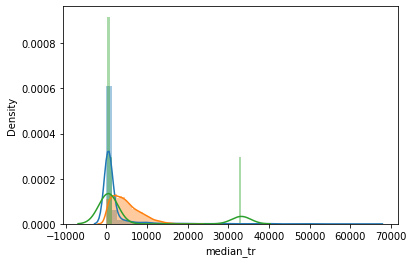

In [334]:
sns.distplot(geo_sample['median_tr'])
sns.distplot(sample_m_m_evo['median_tr'])
sns.distplot(sample_d_d_evo['median_tr'])